# **Práctica de Laboratorio N°07**

> **Asignatura:**
Bioinformática

> **Docente:**
Carlos Fernando Montoya Cubas

> **Estudiante:**
Joseph Timothy Calderon Garmendia(Cód. 182897)

## **Implementación de clase y módulos para la creación y utilizacion de grafos de Bruijn**

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

class BruijnGraph:
    def __init__(self, input_data, k, is_kmers=False):
        """---------------------------------------------------------------------
        Constructor de la clase BruijnGraph.

        Parameters:
        input_data: Secuencia de ADN (str) o lista de k-mers (list of str).
        k         : Int, la longitud de los k-mers.
        is_kmers  : Booleano, si es True, input_data es una lista de k-mers, si
                    es False es una secuencia de ADN.
        ----------------------------------------------------------------------"""
        self.k = k
        if is_kmers:
            # -- Si se proporciona una lista de k-mers
            self.kmers = input_data
        else:
            # -- Si se proporciona una secuencia, dividirla en k-mers
            self.kmers = self._sequence_to_kmers(input_data)

        # -- Construir el grafo de Bruijn
        self.graph = self.build_bruijn_graph()

    def _sequence_to_kmers(self, sequence):
        """---------------------------------------------------------------------
        Convierte una secuencia de ADN en una lista de k-mers.

        Parameters:
        sequence: Secuencia de ADN (str)

        Returns:
        List of k-mers (list of str).
        ---------------------------------------------------------------------"""
        kmers = [sequence[i:i + self.k] for i in range(len(sequence) - self.k + 1)]
        return kmers

    def build_bruijn_graph(self):
        """---------------------------------------------------------------------
        Construye un grafo de Bruijn a partir de la lista de k-mers.

        Returns:
        G: Grafo de Bruijn como un objeto NetworkX.
        ---------------------------------------------------------------------"""
        G = nx.MultiDiGraph()          # -- Multigrafo dirigido

        # -- Itera sobre cada k-mer
        for kmer in self.kmers:
            prefix = kmer[:-1]    # -- Sufijo (primeras k-1 bases)
            suffix = kmer[1:]     # -- Prefijo (últimas k-1 bases)

            # -- Si el prefijo ya existe, agrega el arco (o aumenta el contador si ya existe)
            if G.has_edge(prefix, suffix):
                # -- Si ya existe, obtener la última clave (key) de la arista y acceder a su 'weight'
                last_key = list(G[prefix][suffix].keys())[-1]
                new_weight = G[prefix][suffix][last_key]['weight'] + 1
                # -- Incrementar el 'weight'
                G.add_edge(prefix, suffix, weight=new_weight)
            else:
                # -- Si el prefijo no tiene aristas, añade una nueva
                G.add_edge(prefix, suffix, weight=0)  # -- Agrega el arco entre prefijo y sufijo
        edges = G.edges(data=True, keys=True)

        return G

    def draw_graph(self, layout='circular'):
        """---------------------------------------------------------------------
        Dibuja el grafo de Bruijn en el layout especificado.

        Parameters:
        layout: El tipo de layout para el grafo ('spring' o 'circular').
        ---------------------------------------------------------------------"""
        if layout == 'spring':
            # -- Layout de los nodos en 2D (disposición por "spring")
            pos = nx.spring_layout(self.graph)
        elif layout == 'circular':
            # -- Layout circular para una visualización más clara
            pos = nx.circular_layout(self.graph)
        else:
            raise ValueError("Layout no soportado. Usa 'spring' o 'circular'.")

        # -- Define el tamaño de la figura
        plt.figure(figsize=(13, 9))

        # -- Dibuja los nodos
        nx.draw_networkx_nodes(self.graph, pos, node_size=700, node_color='orange')

        # -- Dibuja las etiquetas de los nodos (k-mers)
        nx.draw_networkx_labels(self.graph, pos, font_size=9, font_color='black')

        # -- Dibuja los arcos (manejo de arcos paralelos)
        # -- Iteramos sobre las aristas y dibujamos los arcos paralelos manualmente
        for (node1, node2, data) in self.graph.edges(data=True):
            # -- Obtener el k-mer asociado a la arista
            kmer = node1 + node2[-1]  # -- El k-mer es la concatenación de la parte final del nodo2 con node1

            # -- Recuperar el peso (si está presente)
            weight = data.get('weight', 0)  # -- Valor por defecto si no hay peso especificado

            # -- Configurar color, tamaño y desplazamiento de las aristas
            offset = 0.15 * weight  # -- Desplazamiento según el peso
            color = 'black'

            # -- Dibujar las aristas, permitiendo desplazamiento para arcos paralelos
            nx.draw_networkx_edges(
                self.graph, pos,
                edgelist=[(node1, node2)],
                edge_color=color,
                arrowstyle='-|>', arrowsize=20,
                width=1, alpha=0.7,
                connectionstyle=f"arc3,rad={offset}"  # -- Desplazamiento radial para arcos paralelos
            )

        # -- Dibuja las etiquetas de los k-mers sobre las aristas
        edge_labels = {}
        for (prefix, suffix, data) in self.graph.edges(data=True):
            # Extrae el k-mer asociado a la arista (usamos el prefijo y sufijo para determinar el k-mer)
            kmer = prefix + suffix[-1]  # La parte final del sufijo corresponde al último carácter del k-mer
            edge_labels[(prefix, suffix)] = kmer

        # -- Dibuja las etiquetas de los k-mers sobre las aristas
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_color='red', font_size=10)

        plt.title('Grafo de Bruijn')
        plt.axis('off') # -- Desactiva los ejes
        plt.show()

    def find_eulerian_path(self):
        """---------------------------------------------------------------------
        Encuentra un camino o ciclo Euleriano en el grafo de Bruijn usando el
        Algoritmo de Hierholzer.

        Returns:
        path: Listado de nodos en el orden del camino/ciclo euleriano.
        ---------------------------------------------------------------------"""
        G = self.graph.copy()  # Copia del grafo original para no modificarlo

        # -- Verificar que el grafo tenga un camino o ciclo euleriano
        in_degrees = {node: G.in_degree(node) for node in G.nodes()}
        out_degrees = {node: G.out_degree(node) for node in G.nodes()}

        # -- Inicializamos contadores para determinar el tipo de camino
        start_node = None
        end_node = None
        for node in G.nodes():
            if out_degrees[node] - in_degrees[node] == 1:
                start_node = node   # -- Nodo de inicio de un camino euleriano
            elif in_degrees[node] - out_degrees[node] == 1:
                end_node = node     # -- Nodo final de un camino euleriano

        # -- Si no se encuentra un nodo de inicio, usamos un ciclo euleriano desde cualquier nodo
        if not start_node:
            start_node = next(iter(G.nodes()))

        # -- Implementación del algoritmo de Hierholzer
        def hierholzer(u):
            """-----------------------------------------------------------------
            Encuentra un ciclo o camino Euleriano comenzando desde el nodo 'u'.
            -----------------------------------------------------------------"""
            stack = [u]
            path = []
            while stack:
                v = stack[-1]
                if G.out_degree(v) > 0:
                    # -- Convertir la vista de aristas en un iterador
                    out_edges = iter(G.out_edges(v, keys=True))
                    _, w, key = next(out_edges)  # Tomar el primer arco disponible
                    stack.append(w)
                    # -- Removemos la arista del grafo
                    G.remove_edge(v, w, key=key)
                else:
                    # -- Si no hay aristas restantes, retrocedemos
                    path.append(stack.pop())
            return path

        # -- Aplicamos Hierholzer y construimos el camino o ciclo euleriano
        eulerian_path = hierholzer(start_node)

        # -- El ciclo/camino se construye al revés, así que lo invertimos
        return eulerian_path[::-1]

## **Prueba con ejercicio de clase**

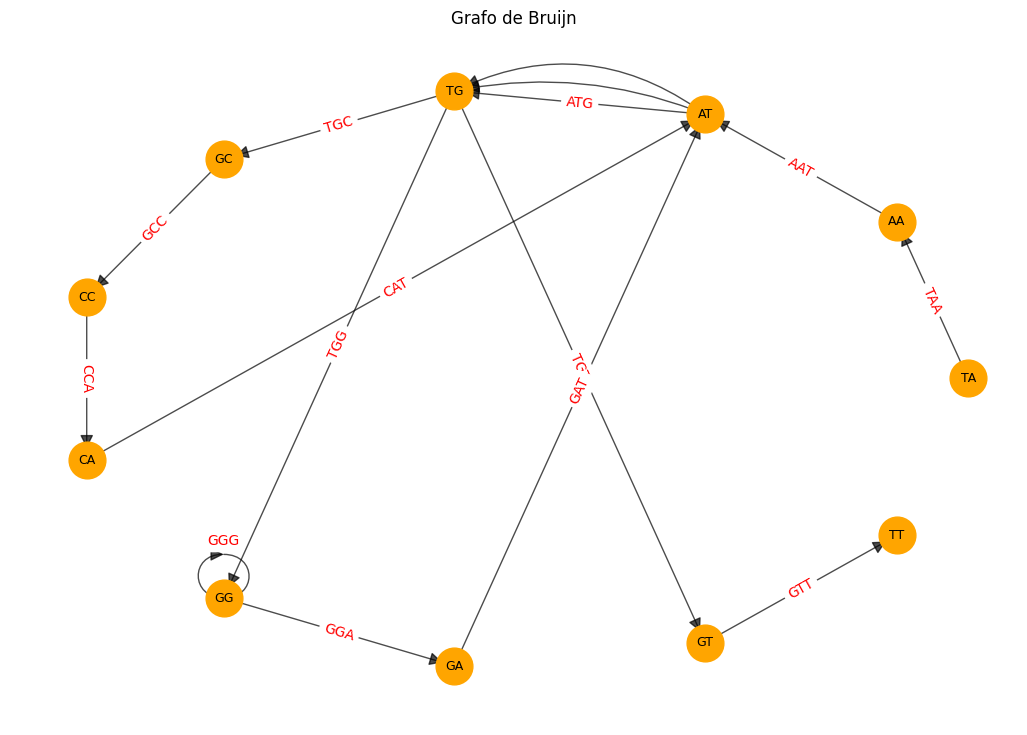

Camino Euleriano: ['TA', 'AA', 'AT', 'TG', 'GC', 'CC', 'CA', 'AT', 'TG', 'GG', 'GG', 'GA', 'AT', 'TG', 'GT', 'TT']


In [21]:
# -- Crear el grafo de Bruijn a partir de una secuencia y k
sequence = 'TAATGCCATGGGATGTT'
k = 3

# -- Crear el grafo de Bruijn a partir de la secuencia
bruijn_graph = BruijnGraph(sequence, k)

# -- Dibujar el grafo de Bruijn
bruijn_graph.draw_graph(layout='circular')

# -- Encontrar el camino Euleriano en el grafo de Bruijn
eulerian_path = bruijn_graph.find_eulerian_path()

# -- Mostrar el camino Euleriano encontrado
print("Camino Euleriano:", eulerian_path)

## **Secuencia dividida en K-mers, con K = 3**

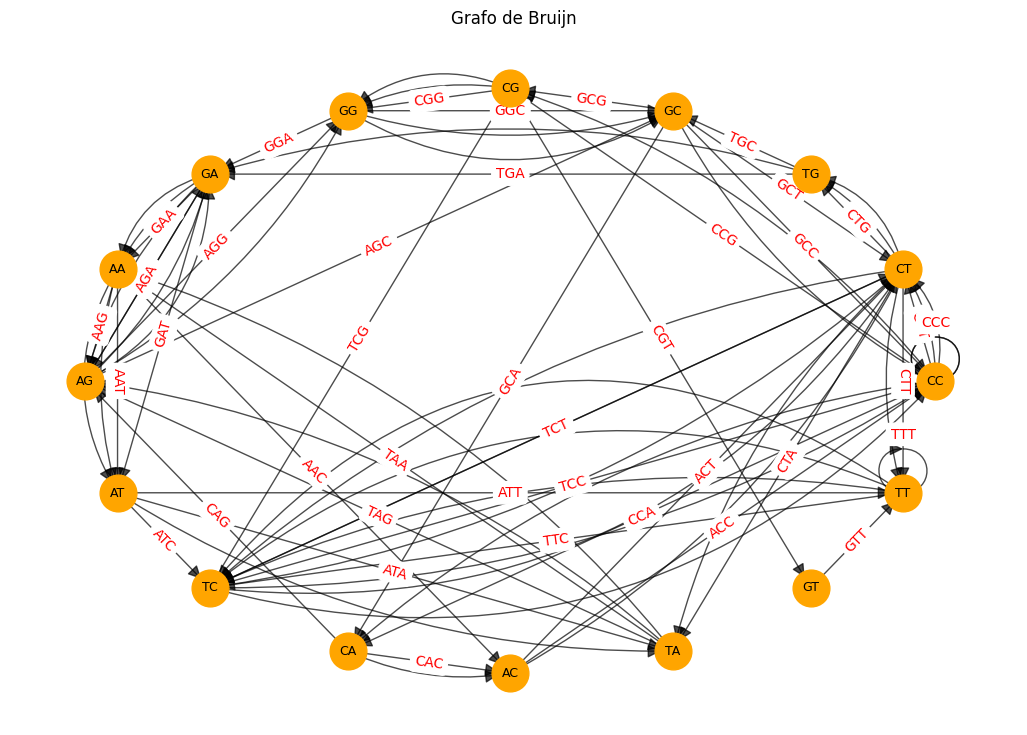

Camino Euleriano: ['CC', 'CT', 'TG', 'GC', 'CG', 'GG', 'GA', 'AA', 'AG', 'GA', 'AA', 'AT', 'TC', 'CG', 'GG', 'GC', 'CA', 'AC', 'CT', 'TG', 'GA', 'AA', 'AT', 'TA', 'AG', 'GA', 'AT', 'TA', 'AG', 'GA', 'AG', 'GC', 'CC', 'CT', 'TG', 'GA', 'AG', 'GG', 'GC', 'CC', 'CT', 'TA', 'AA', 'AT', 'TT', 'TT', 'TC', 'CT', 'TA', 'AA', 'AC', 'CT', 'TC', 'CT', 'TC', 'CT', 'TT', 'TC', 'CC', 'CA', 'AC', 'CC', 'CA', 'AG', 'GG', 'GC', 'CT', 'TT', 'TC', 'CC', 'CG', 'GT', 'TT', 'TC', 'CC', 'CC', 'CC', 'CG', 'GG']


In [22]:
# -- Crear el grafo de Bruijn a partir de una secuencia y k
sequence = 'CCTGCGGAAGATCGGCACTAGAATAGCCAGAACCGTTTCTCTGAGGCTTCCGGCCTTCCCTCCCACTAATAATTCTGAGG'
k = 3

# -- Crear el grafo de Bruijn a partir de la secuencia
bruijn_graph = BruijnGraph(sequence, k)

# -- Dibujar el grafo de Bruijn
bruijn_graph.draw_graph(layout='circular')

# -- Encontrar el camino Euleriano en el grafo de Bruijn
eulerian_path = bruijn_graph.find_eulerian_path()

# -- Mostrar el camino Euleriano encontrado
print("Camino Euleriano:", eulerian_path)

## **Secuencia dividida en K-mers, con K = 4**

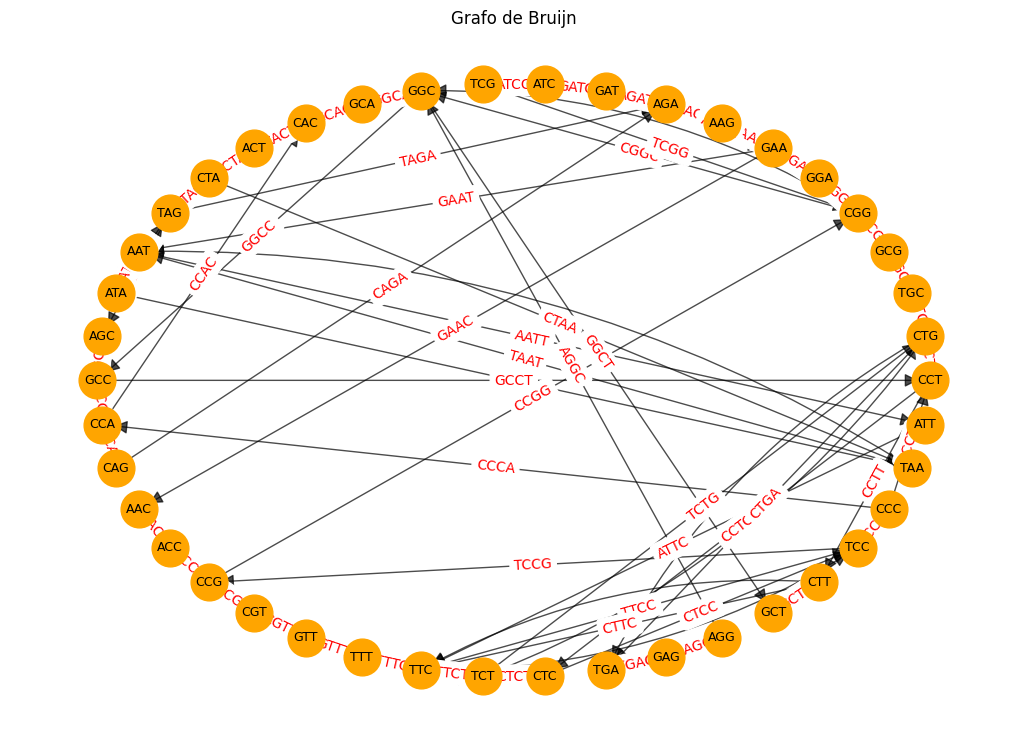

Camino Euleriano: ['CCT', 'CTG', 'TGC', 'GCG', 'CGG', 'GGA', 'GAA', 'AAG', 'AGA', 'GAT', 'ATC', 'TCG', 'CGG', 'GGC', 'GCA', 'CAC', 'ACT', 'CTA', 'TAG', 'AGA', 'GAA', 'AAT', 'ATA', 'TAG', 'AGC', 'GCC', 'CCA', 'CAG', 'AGA', 'GAA', 'AAC', 'ACC', 'CCG', 'CGT', 'GTT', 'TTT', 'TTC', 'TCT', 'CTC', 'TCT', 'CTG', 'TGA', 'GAG', 'AGG', 'GGC', 'GCT', 'CTT', 'TTC', 'TCC', 'CCG', 'CGG', 'GGC', 'GCC', 'CCT', 'CTT', 'TTC', 'TCC', 'CCC', 'CCT', 'CTC', 'TCC', 'CCC', 'CCA', 'CAC', 'ACT', 'CTA', 'TAA', 'AAT', 'ATA', 'TAA', 'AAT', 'ATT', 'TTC', 'TCT', 'CTG', 'TGA', 'GAG', 'AGG']


In [23]:
# -- Crear el grafo de Bruijn a partir de una secuencia y k
sequence = 'CCTGCGGAAGATCGGCACTAGAATAGCCAGAACCGTTTCTCTGAGGCTTCCGGCCTTCCCTCCCACTAATAATTCTGAGG'
k = 4

# -- Crear el grafo de Bruijn a partir de la secuencia
bruijn_graph = BruijnGraph(sequence, k)

# -- Dibujar el grafo de Bruijn
bruijn_graph.draw_graph(layout='circular')

# -- Encontrar el camino Euleriano en el grafo de Bruijn
eulerian_path = bruijn_graph.find_eulerian_path()

# -- Mostrar el camino Euleriano encontrado
print("Camino Euleriano:", eulerian_path)

## **Secuencia dividida en K-mers, con K = 5**

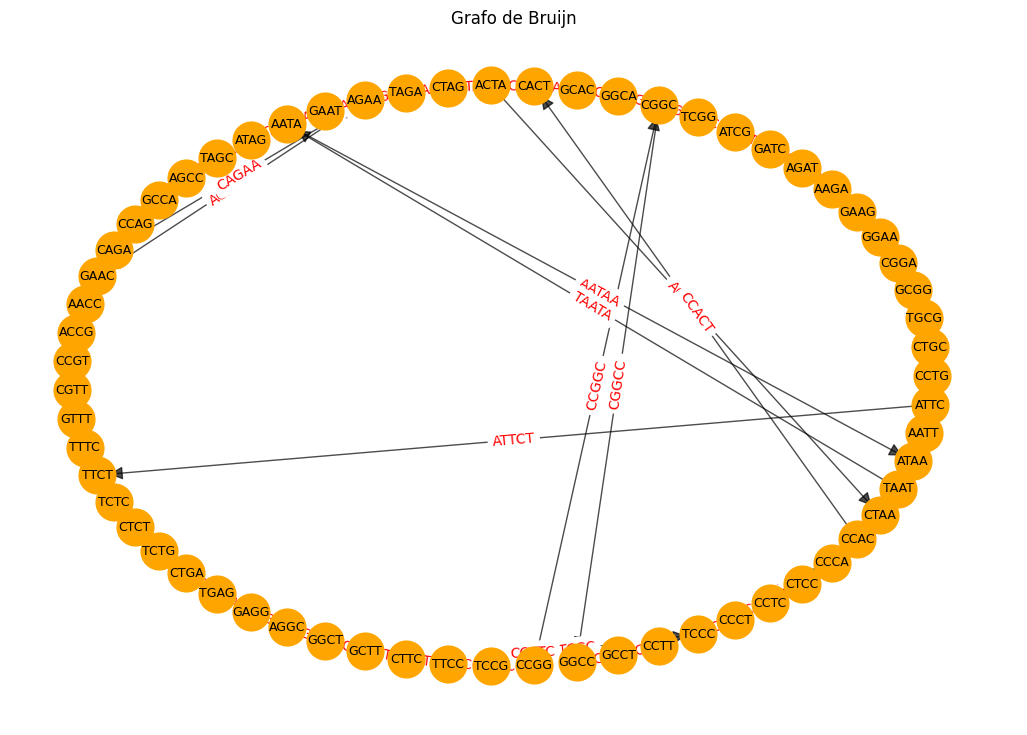

Camino Euleriano: ['CCTG', 'CTGC', 'TGCG', 'GCGG', 'CGGA', 'GGAA', 'GAAG', 'AAGA', 'AGAT', 'GATC', 'ATCG', 'TCGG', 'CGGC', 'GGCA', 'GCAC', 'CACT', 'ACTA', 'CTAG', 'TAGA', 'AGAA', 'GAAT', 'AATA', 'ATAG', 'TAGC', 'AGCC', 'GCCA', 'CCAG', 'CAGA', 'AGAA', 'GAAC', 'AACC', 'ACCG', 'CCGT', 'CGTT', 'GTTT', 'TTTC', 'TTCT', 'TCTC', 'CTCT', 'TCTG', 'CTGA', 'TGAG', 'GAGG', 'AGGC', 'GGCT', 'GCTT', 'CTTC', 'TTCC', 'TCCG', 'CCGG', 'CGGC', 'GGCC', 'GCCT', 'CCTT', 'CTTC', 'TTCC', 'TCCC', 'CCCT', 'CCTC', 'CTCC', 'TCCC', 'CCCA', 'CCAC', 'CACT', 'ACTA', 'CTAA', 'TAAT', 'AATA', 'ATAA', 'TAAT', 'AATT', 'ATTC', 'TTCT', 'TCTG', 'CTGA', 'TGAG', 'GAGG']


In [24]:
# -- Crear el grafo de Bruijn a partir de una secuencia y k
sequence = 'CCTGCGGAAGATCGGCACTAGAATAGCCAGAACCGTTTCTCTGAGGCTTCCGGCCTTCCCTCCCACTAATAATTCTGAGG'
k = 5

# -- Crear el grafo de Bruijn a partir de la secuencia
bruijn_graph = BruijnGraph(sequence, k)

# -- Dibujar el grafo de Bruijn
bruijn_graph.draw_graph(layout='circular')

# -- Encontrar el camino Euleriano en el grafo de Bruijn
eulerian_path = bruijn_graph.find_eulerian_path()

# -- Mostrar el camino Euleriano encontrado
print("Camino Euleriano:", eulerian_path)

## **Búsqueda de todos los caminos eulerianos**

### **Clase y Múdulos Base**

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

class GrafoDeBruijn:
    def __init__(self, k):
        """---------------------------------------------------------------------
        Inicializa el grafo de Bruijn.
        ---------------------------------------------------------------------"""
        self.k = k
        self.grafo = defaultdict(list)      # -- Diccionario para almacenar los nodos y aristas
        self.aristas = []                   # -- Lista para almacenar las aristas con su respectivo k-mer
        self.in_degree = defaultdict(int)   # -- Grados de entrada de los nodos
        self.out_degree = defaultdict(int)  # -- Grados de salida de los nodos

    def agregar_kmer(self, kmer):
        """---------------------------------------------------------------------
        Añade un k-mer al grafo de Bruijn.
        ---------------------------------------------------------------------"""
        prefijo = kmer[:-1]  # -- El prefijo del (k-1)-mer
        sufijo = kmer[1:]    # -- El sufijo del (k-1)-mer

        # -- Añadir el sufijo como vecino del prefijo
        self.grafo[prefijo].append(sufijo)
        self.aristas.append((prefijo, sufijo, kmer))

        # -- Incrementar los grados de entrada y salida
        self.out_degree[prefijo] += 1
        self.in_degree[sufijo] += 1

    def construir_grafo(self, seq):
        """---------------------------------------------------------------------
        Construye el grafo de Bruijn a partir de una secuencia de ADN.
        ---------------------------------------------------------------------"""
        for i in range(len(seq) - self.k + 1):
            kmer = seq[i:i + self.k]
            self.agregar_kmer(kmer)

    def mostrar_grafo(self):
        """---------------------------------------------------------------------
        Muestra el grafo de Bruijn usando networkx y matplotlib.
        ---------------------------------------------------------------------"""
        G = nx.DiGraph()

        # Añadir nodos y aristas al grafo de networkx
        for prefijo, sufijo, kmer in self.aristas:
            G.add_edge(prefijo, sufijo, label=kmer)

        # Dibujar el grafo con etiquetas de aristas
        plt.figure(figsize=(8, 6))  # Aumentar el tamaño de la figura
        pos = nx.shell_layout(G)  # Layout para una mejor disposición de los nodos
        nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue',
                font_size=10, font_weight='bold', arrows=True, arrowstyle='-|>',
                arrowsize=12)

        # Dibujar las etiquetas de los k-mers sobre las aristas
        edge_labels = {(prefijo, sufijo): kmer for prefijo, sufijo, kmer in self.aristas}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

        # Mostrar el grafo
        plt.title("Grafo de Bruijn")
        plt.show()

    def mostrar_caminos(self, caminos):
        """---------------------------------------------------------------------
        Muestra los caminos eulerianos encontrados.
        ---------------------------------------------------------------------"""
        for i, camino in enumerate(caminos):
            print(f"Camino Euleriano {i+1}: {' -> '.join(camino)}")

    # ======================================================================== #

    def encontrar_todos_caminos_eulerianos(self):
        """---------------------------------------------------------------------
        Encuentra todos los caminos eulerianos posibles en el grafo de Bruijn.
        ---------------------------------------------------------------------"""
        caminos_eulerianos = []

        # Revisar si el grafo tiene un camino euleriano
        if not self._verificar_grafo_euleriano():
            return caminos_eulerianos  # No hay caminos eulerianos si no cumple con las condiciones

        # Identificar el nodo de inicio para el camino euleriano
        for nodo in self.grafo:
            if self.out_degree[nodo] - self.in_degree[nodo] == 1:
                inicio = nodo
                break
        else:
            inicio = next(iter(self.grafo))

        # Encontrar caminos eulerianos desde diferentes posibles rutas
        self._hierholzer_todos(inicio, [], caminos_eulerianos)

        return caminos_eulerianos

    def _verificar_grafo_euleriano(self):
        """---------------------------------------------------------------------
        Verifica si el grafo cumple las condiciones para tener caminos eulerianos.
        ---------------------------------------------------------------------"""
        in_out_diff = 0
        for nodo in self.grafo:
            if abs(self.out_degree[nodo] - self.in_degree[nodo]) > 1:
                return False
            if self.out_degree[nodo] - self.in_degree[nodo] == 1:
                in_out_diff += 1
        return in_out_diff <= 1

    def _hierholzer_todos(self, nodo, ruta_actual, caminos_eulerianos):
        """---------------------------------------------------------------------
        Modificación del algoritmo de Hierholzer para encontrar todos los caminos eulerianos.
        ---------------------------------------------------------------------"""
        while self.grafo[nodo]:
            siguiente = self.grafo[nodo].pop()
            self._hierholzer_todos(siguiente, ruta_actual, caminos_eulerianos)

        ruta_actual.append(nodo)

        # Si el recorrido está completo, agregar el camino a la lista
        if all(len(sucesores) == 0 for sucesores in self.grafo.values()):
            caminos_eulerianos.append(ruta_actual[::-1])

### **Algoritmo | Intento 1**

In [26]:
def _hierholzer_modificado(self, nodo, ruta, visitadas):
        """---------------------------------------------------------------------
        Algoritmo de Hierholzer modificado para encontrar todos los caminos
        eulerianos.
        ---------------------------------------------------------------------"""
        # Hacer una copia de las aristas originales para este camino
        aristas_originales = self.grafo[nodo][:]

        while self.grafo[nodo]:
            siguiente = self.grafo[nodo].pop()
            visitadas.append((nodo, siguiente))
            self._hierholzer_modificado(siguiente, ruta, visitadas)

        ruta.append(nodo)
        # Restaurar las aristas para que puedan ser exploradas en futuros recorridos
        self.grafo[nodo] = aristas_originales

def encontrar_caminos_eulerianos(self):
        """---------------------------------------------------------------------
        Encuentra todos los caminos eulerianos en el grafo de Bruijn.
        ---------------------------------------------------------------------"""
        # Comprobar las condiciones necesarias para la existencia de un camino Euleriano
        num_inicio = 0
        num_final = 0
        inicio = None

        for nodo in self.grafo:
            if self.out_degree[nodo] - self.in_degree[nodo] == 1:
                num_inicio += 1
                inicio = nodo
            elif self.in_degree[nodo] - self.out_degree[nodo] == 1:
                num_final += 1

        if num_inicio > 1 or num_final > 1:
            print("No es posible tener un camino euleriano en este grafo.")
            return []

        if inicio is None:
            inicio = next(iter(self.grafo))  # Escoge cualquier nodo si no hay nodo inicial específico.

        # Encontrar todos los caminos eulerianos utilizando una copia del grafo
        caminos = []
        self._encontrar_todos_los_caminos(inicio, caminos)
        return caminos

def _encontrar_todos_los_caminos(self, nodo, caminos):
        """---------------------------------------------------------------------
        Encuentra todos los caminos eulerianos explorando cada arista.
        ---------------------------------------------------------------------"""
        ruta = []
        visitadas = []

        # Usar el algoritmo de Hierholzer modificado para encontrar el camino euleriano
        self._hierholzer_modificado(nodo, ruta, visitadas)

        # Almacenar el camino encontrado
        if len(visitadas) == len(self.aristas):  # Se debe haber recorrido todas las aristas
            caminos.append(ruta[::-1])  # Agregar la ruta en orden inverso

### **Algortimo | Intento 2**

In [27]:
def encontrar_todos_caminos_eulerianos(self):
        """---------------------------------------------------------------------
        Encuentra todos los caminos eulerianos posibles en el grafo de Bruijn.
        ---------------------------------------------------------------------"""
        caminos_eulerianos = []

        # Revisar si el grafo tiene un camino euleriano
        if not self._verificar_grafo_euleriano():
            return caminos_eulerianos  # No hay caminos eulerianos si no cumple con las condiciones

        # Identificar el nodo de inicio para el camino euleriano
        for nodo in self.grafo:
            if self.out_degree[nodo] - self.in_degree[nodo] == 1:
                inicio = nodo
                break
        else:
            inicio = next(iter(self.grafo))

        # Encontrar caminos eulerianos desde diferentes posibles rutas
        self._hierholzer_todos(inicio, [], caminos_eulerianos)

        return caminos_eulerianos

def _verificar_grafo_euleriano(self):
        """---------------------------------------------------------------------
        Verifica si el grafo cumple las condiciones para tener caminos eulerianos.
        ---------------------------------------------------------------------"""
        in_out_diff = 0
        for nodo in self.grafo:
            if abs(self.out_degree[nodo] - self.in_degree[nodo]) > 1:
                return False
            if self.out_degree[nodo] - self.in_degree[nodo] == 1:
                in_out_diff += 1
        return in_out_diff <= 1

def _hierholzer_todos(self, nodo, ruta_actual, caminos_eulerianos):
        """---------------------------------------------------------------------
        Modificación del algoritmo de Hierholzer para encontrar todos los caminos eulerianos.
        ---------------------------------------------------------------------"""
        while self.grafo[nodo]:
            siguiente = self.grafo[nodo].pop()
            self._hierholzer_todos(siguiente, ruta_actual, caminos_eulerianos)

        ruta_actual.append(nodo)

        # Si el recorrido está completo, agregar el camino a la lista
        if all(len(sucesores) == 0 for sucesores in self.grafo.values()):
            caminos_eulerianos.append(ruta_actual[::-1])


### **Programa Principal**

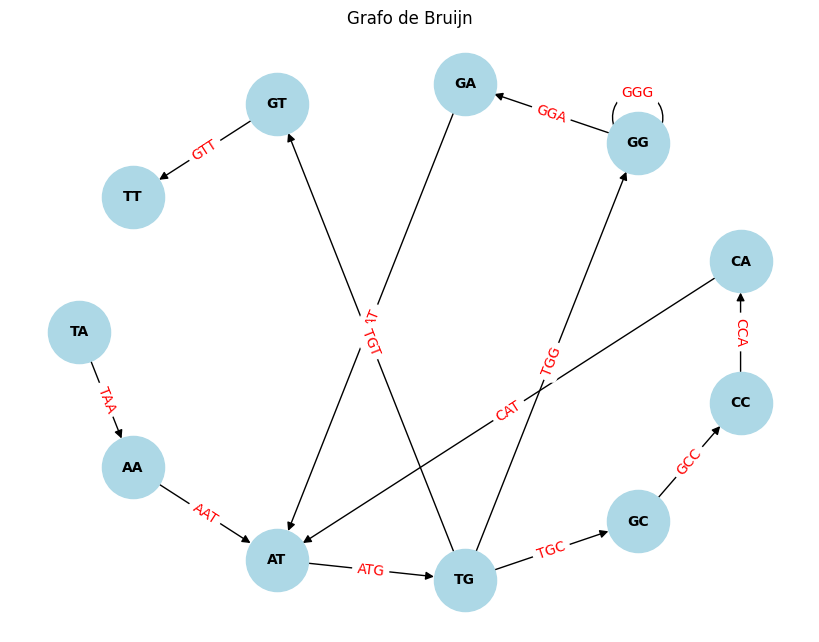

Camino Euleriano 1: GG -> GA -> AT -> TG -> GC -> CC -> CA -> AT -> TG -> GT -> TT
Camino Euleriano 2: GG -> GG -> GA -> AT -> TG -> GC -> CC -> CA -> AT -> TG -> GT -> TT
Camino Euleriano 3: TG -> GG -> GG -> GA -> AT -> TG -> GC -> CC -> CA -> AT -> TG -> GT -> TT
Camino Euleriano 4: AT -> TG -> GG -> GG -> GA -> AT -> TG -> GC -> CC -> CA -> AT -> TG -> GT -> TT
Camino Euleriano 5: AA -> AT -> TG -> GG -> GG -> GA -> AT -> TG -> GC -> CC -> CA -> AT -> TG -> GT -> TT
Camino Euleriano 6: TA -> AA -> AT -> TG -> GG -> GG -> GA -> AT -> TG -> GC -> CC -> CA -> AT -> TG -> GT -> TT


In [28]:
# -- Crear una instancia del grafo de Bruijn con k=3
dbg = GrafoDeBruijn(k=3)

# -- Secuencia de ADN
sequence = "TAATGCCATGGGATGTT"

# -- Construir el grafo de Bruijn a partir de la secuencia
dbg.construir_grafo(sequence)

# -- Mostrar el grafo resultante
dbg.mostrar_grafo()

# -- Encontrar y mostrar todos los caminos eulerianos
caminos_eulerianos = dbg.encontrar_todos_caminos_eulerianos()
dbg.mostrar_caminos(caminos_eulerianos)

## **Implementación de clase y módulos para la gestión grafos de Bruijn con tuplas de k-mers**

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

class GrafoDeBruijn:
    def __init__(self, k):
        """---------------------------------------------------------------------
        Inicializa el grafo de Bruijn.
        ---------------------------------------------------------------------"""
        self.k = k
        self.grafo = defaultdict(list)      # -- Diccionario para almacenar los nodos y aristas
        self.aristas = []                   # -- Lista para almacenar las aristas con su respectivo k-mer
        self.in_degree = defaultdict(int)   # -- Grados de entrada de los nodos
        self.out_degree = defaultdict(int)  # -- Grados de salida de los nodos

    def agregar_kmer(self, kmer):
        """---------------------------------------------------------------------
        Añade un k-mer al grafo de Bruijn.
        ---------------------------------------------------------------------"""
        prefijo = (kmer[0][:-1], kmer[1][:-1])  # -- El prefijo del (k-1)-mer
        sufijo = (kmer[0][1:], kmer[1][1:])     # -- El sufijo del (k-1)-mer

        # -- Añadir el sufijo como vecino del prefijo
        self.grafo[prefijo].append(sufijo)
        self.aristas.append((prefijo, sufijo, kmer))

        # -- Incrementar los grados de entrada y salida
        self.out_degree[prefijo] += 1
        self.in_degree[sufijo] += 1

    def construir_grafo(self, seq):
        """---------------------------------------------------------------------
        Construye el grafo de Bruijn a partir de una secuencia de ADN.
        ---------------------------------------------------------------------"""
        for i in range(len(seq) - 6):
            self.agregar_kmer((seq[i:i+3], seq[i+4:i+7]))

        print()
        print(self.grafo)
        print(self.aristas)
        print()

    def mostrar_grafo(self):
        """---------------------------------------------------------------------
        Muestra el grafo de Bruijn usando networkx y matplotlib.
        ---------------------------------------------------------------------"""
        G = nx.DiGraph()

        # Añadir nodos y aristas al grafo de networkx
        for prefijo, sufijo, kmer in self.aristas:
            G.add_edge(prefijo, sufijo, label=kmer)

        # Dibujar el grafo con etiquetas de aristas
        plt.figure(figsize=(12, 8))  # Aumentar el tamaño de la figura
        pos = nx.circular_layout(G)  # Layout para una mejor disposición de los nodos
        nx.draw(G, pos, with_labels=True, node_size=2000, node_color='orange',
                font_size=6, font_weight='bold', arrows=True, arrowstyle='-|>',
                arrowsize=12)

        # Dibujar las etiquetas de los k-mers sobre las aristas
        edge_labels = {(prefijo, sufijo): kmer for prefijo, sufijo, kmer in self.aristas}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, font_color='red')

        # Mostrar el grafo
        plt.title("Grafo de Bruijn")
        plt.show()

    def _hierholzer(self, nodo, ruta):
        """---------------------------------------------------------------------
        Algoritmo de Hierholzer para encontrar un camino euleriano.
        ---------------------------------------------------------------------"""
        while self.grafo[nodo]:
            siguiente = self.grafo[nodo].pop()
            self._hierholzer(siguiente, ruta)
        ruta.append(nodo)

    def encontrar_caminos_eulerianos(self):
        """---------------------------------------------------------------------
        Encuentra todos los caminos eulerianos en el grafo de Bruijn.
        ---------------------------------------------------------------------"""
        # Identificar el nodo de inicio para el camino euleriano
        inicio = None
        for nodo in self.grafo:
            if self.out_degree[nodo] - self.in_degree[nodo] == 1:
                inicio = nodo
                break
        if inicio is None:
            # Si no se encontró un nodo con un grado de salida mayor, tomar cualquier nodo
            inicio = next(iter(self.grafo))

        # Realizar el recorrido utilizando el algoritmo de Hierholzer
        ruta = []
        self._hierholzer(inicio, ruta)
        return ruta[::-1]  # La ruta se construye en orden inverso

## **Prueba de con ejercicio de clase**


defaultdict(<class 'list'>, {('TA', 'GC'): [('AA', 'CC')], ('AA', 'CC'): [('AT', 'CA')], ('AT', 'CA'): [('TG', 'AT')], ('TG', 'AT'): [('GC', 'TG'), ('GG', 'TG')], ('GC', 'TG'): [('CC', 'GG')], ('CC', 'GG'): [('CA', 'GG')], ('CA', 'GG'): [('AT', 'GA')], ('AT', 'GA'): [('TG', 'AT')], ('GG', 'TG'): [('GG', 'GT')], ('GG', 'GT'): [('GA', 'TT')]})
[(('TA', 'GC'), ('AA', 'CC'), ('TAA', 'GCC')), (('AA', 'CC'), ('AT', 'CA'), ('AAT', 'CCA')), (('AT', 'CA'), ('TG', 'AT'), ('ATG', 'CAT')), (('TG', 'AT'), ('GC', 'TG'), ('TGC', 'ATG')), (('GC', 'TG'), ('CC', 'GG'), ('GCC', 'TGG')), (('CC', 'GG'), ('CA', 'GG'), ('CCA', 'GGG')), (('CA', 'GG'), ('AT', 'GA'), ('CAT', 'GGA')), (('AT', 'GA'), ('TG', 'AT'), ('ATG', 'GAT')), (('TG', 'AT'), ('GG', 'TG'), ('TGG', 'ATG')), (('GG', 'TG'), ('GG', 'GT'), ('GGG', 'TGT')), (('GG', 'GT'), ('GA', 'TT'), ('GGA', 'GTT'))]



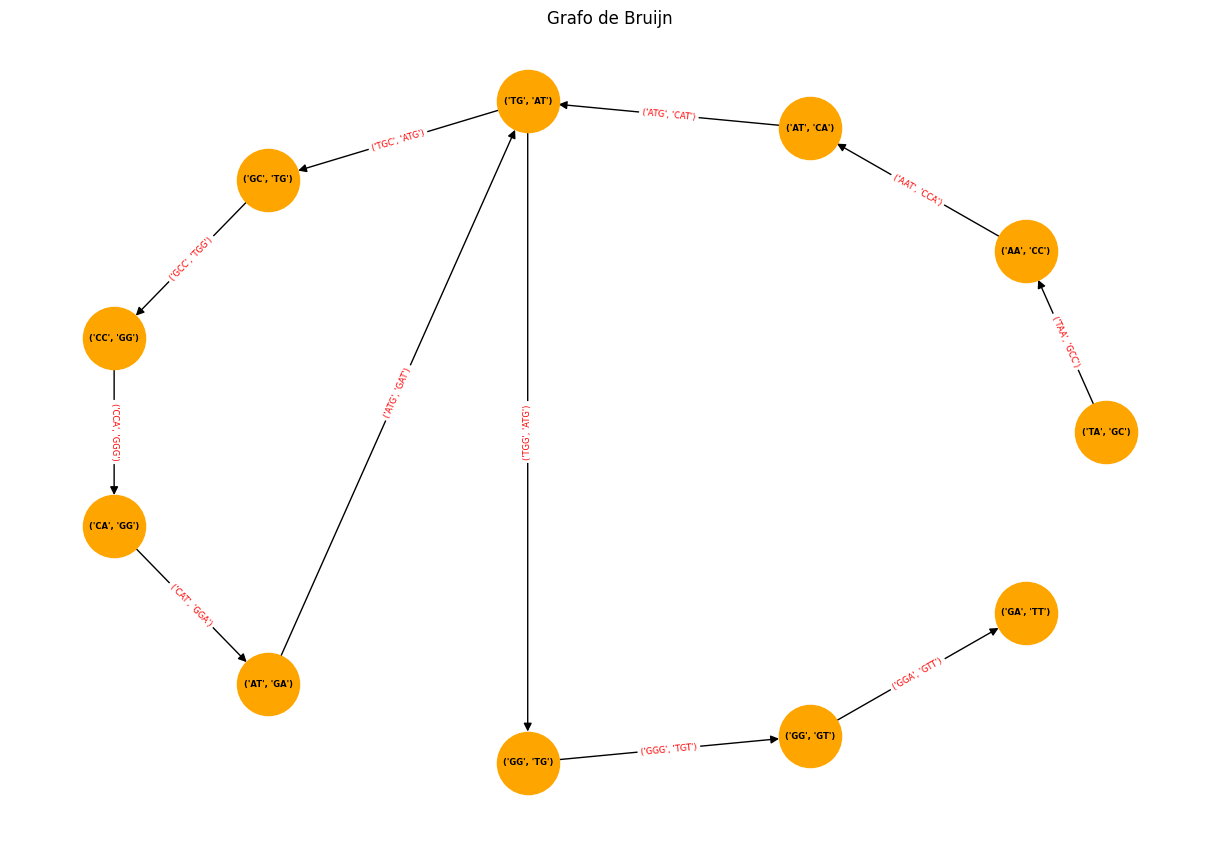

Camino euleriano: ('TA', 'GC') -> ('AA', 'CC') -> ('AT', 'CA') -> ('TG', 'AT') -> ('GC', 'TG') -> ('CC', 'GG') -> ('CA', 'GG') -> ('AT', 'GA') -> ('TG', 'AT') -> ('GG', 'TG') -> ('GG', 'GT') -> ('GA', 'TT')


In [30]:
# -- Crear una instancia del grafo de Bruijn con k=3
dbg = GrafoDeBruijn(k=3)

# -- Secuencia de ADN
sequence = "TAATGCCATGGGATGTT"

# -- Construir el grafo de Bruijn a partir de la secuencia
dbg.construir_grafo(sequence)

# -- Mostrar el grafo resultante
dbg.mostrar_grafo()

# -- Encontrar y mostrar el camino euleriano
camino_euleriano = dbg.encontrar_caminos_eulerianos()
print(f"Camino euleriano: {' -> '.join(map(str, camino_euleriano))}")

## **Ejercicio Propuesto**


defaultdict(<class 'list'>, {('TA', 'GC'): [('AA', 'CC')], ('AA', 'CC'): [('AT', 'CC')], ('AT', 'CC'): [('TG', 'CT'), ('TA', 'CA')], ('TG', 'CT'): [('GC', 'TG')], ('GC', 'TG'): [('CC', 'GC')], ('CC', 'GC'): [('CC', 'CG')], ('CC', 'CG'): [('CT', 'GG')], ('CT', 'GG'): [('TG', 'GA'), ('TG', 'GC'), ('TG', 'GC')], ('TG', 'GA'): [('GC', 'AA')], ('GC', 'AA'): [('CG', 'AG')], ('CG', 'AG'): [('GG', 'GA')], ('GG', 'GA'): [('GA', 'AT')], ('GA', 'AT'): [('AA', 'TC')], ('AA', 'TC'): [('AG', 'CG')], ('AG', 'CG'): [('GA', 'GG')], ('GA', 'GG'): [('AT', 'GC')], ('AT', 'GC'): [('TC', 'CA')], ('TC', 'CA'): [('CG', 'AC')], ('CG', 'AC'): [('GG', 'CT')], ('GG', 'CT'): [('GC', 'TA')], ('GC', 'TA'): [('CA', 'AG')], ('CA', 'AG'): [('AC', 'GA')], ('AC', 'GA'): [('CT', 'AA')], ('CT', 'AA'): [('TA', 'AT')], ('TA', 'AT'): [('AG', 'TA')], ('AG', 'TA'): [('GA', 'AG')], ('GA', 'AG'): [('AA', 'GC')], ('AA', 'GC'): [('AT', 'CC')], ('TA', 'CA'): [('AG', 'AG')], ('AG', 'AG'): [('GC', 'GA')], ('GC', 'GA'): [('CC', 'AA')]

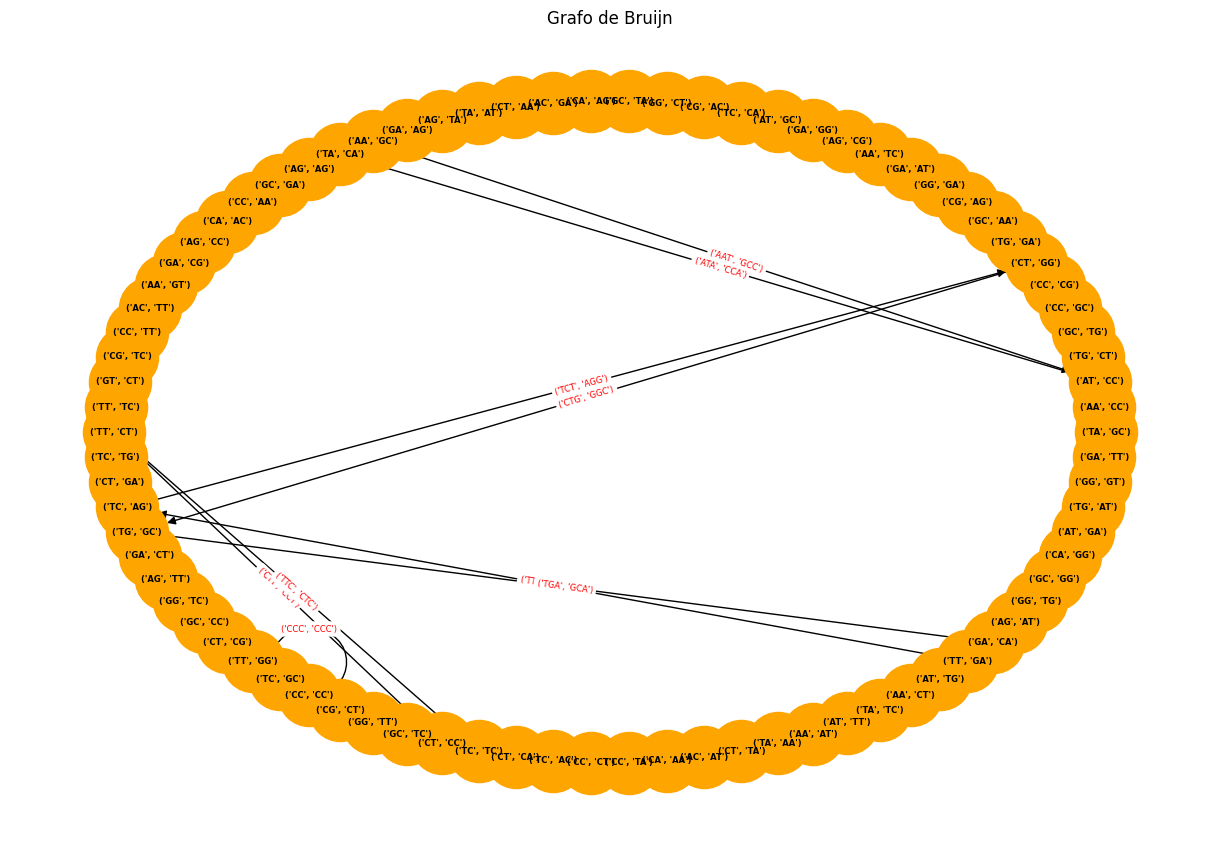

Camino euleriano: ('TA', 'GC') -> ('AA', 'CC') -> ('AT', 'CC') -> ('TA', 'CA') -> ('AG', 'AG') -> ('GC', 'GA') -> ('CC', 'AA') -> ('CA', 'AC') -> ('AG', 'CC') -> ('GA', 'CG') -> ('AA', 'GT') -> ('AC', 'TT') -> ('CC', 'TT') -> ('CG', 'TC') -> ('GT', 'CT') -> ('TT', 'TC') -> ('TT', 'CT') -> ('TC', 'TC') -> ('CC', 'CC') -> ('CT', 'CA') -> ('TC', 'AC') -> ('CC', 'CT') -> ('CC', 'TA') -> ('CA', 'AA') -> ('AC', 'AT') -> ('CT', 'TA') -> ('TA', 'AA') -> ('AA', 'AT') -> ('AT', 'TT') -> ('TA', 'TC') -> ('AA', 'CT') -> ('AT', 'TG') -> ('TT', 'GA') -> ('TC', 'AG') -> ('CT', 'GG') -> ('TG', 'GC') -> ('GA', 'CT') -> ('AG', 'TT') -> ('GG', 'TC') -> ('GC', 'CC') -> ('CT', 'CG') -> ('TT', 'GG') -> ('TC', 'GC') -> ('CC', 'CC') -> ('CC', 'CC') -> ('CG', 'CT') -> ('GG', 'TT') -> ('GC', 'TC') -> ('CC', 'CC') -> ('CT', 'CC') -> ('TT', 'CT') -> ('TC', 'TG') -> ('CT', 'GA') -> ('TC', 'AG') -> ('CT', 'GG') -> ('TG', 'GA') -> ('GC', 'AA') -> ('CG', 'AG') -> ('GG', 'GA') -> ('GA', 'AT') -> ('AA', 'TC') -> ('AG',

In [31]:
# -- Crear una instancia del grafo de Bruijn con k=3
dbg = GrafoDeBruijn(k=3)

# -- Secuencia de ADN
sequence = "TAATGCCCTGCGGAAGATCGGCACTAGAATAGCCAGAACCGTTTCTCTGAGGCTTCCGGCCTTCCCTCCCACTAATAATTCTGAGGCATGGGATGTT"

# -- Construir el grafo de Bruijn a partir de la secuencia
dbg.construir_grafo(sequence)

# -- Mostrar el grafo resultante
dbg.mostrar_grafo()

# -- Encontrar y mostrar el camino euleriano
camino_euleriano = dbg.encontrar_caminos_eulerianos()
print(f"Camino euleriano: {' -> '.join(map(str, camino_euleriano))}")